=== Wisconsin Breast Cancer Dataset Analysis ===
Comparing PCA, Kernel PCA, and UMAP for dimensionality reduction

Dataset shape: (569, 30)
Number of features: 30
Number of samples: 569
Classes: ['malignant' 'benign']
Class distribution: [212 357]

First few rows of the dataset:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974   

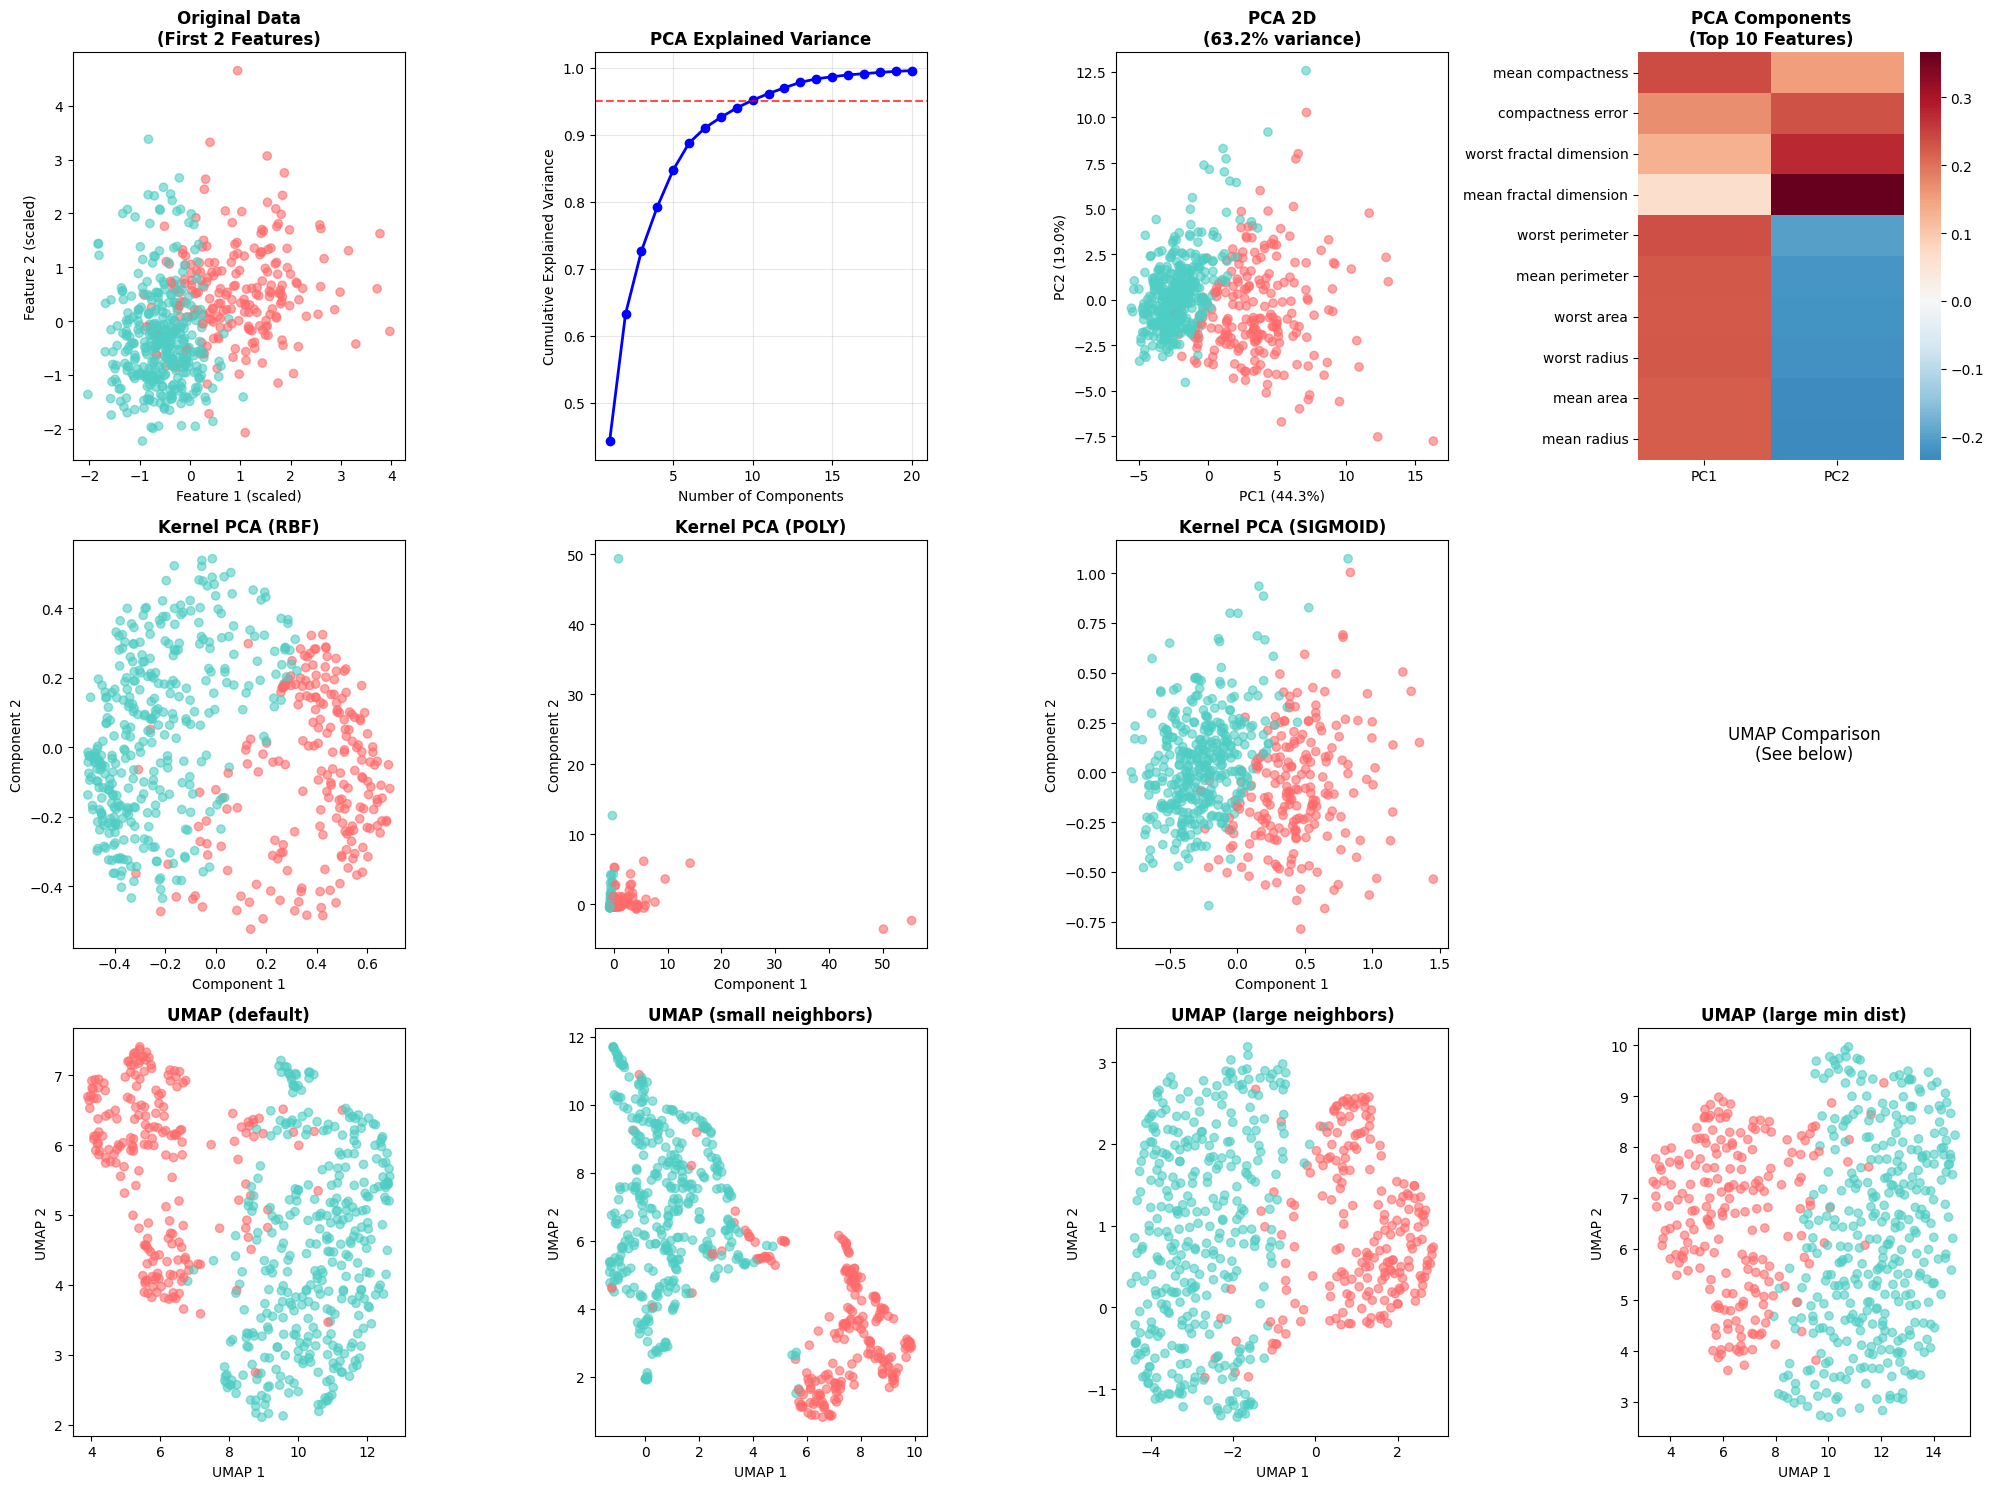


QUANTITATIVE ANALYSIS

PCA (2D):
  Accuracy on reduced data: 0.947
  Accuracy on original data: 0.936
  Relative performance: 1.012

Kernel PCA (RBF):
  Accuracy on reduced data: 0.930
  Accuracy on original data: 0.936
  Relative performance: 0.994

UMAP (default):
  Accuracy on reduced data: 0.947
  Accuracy on original data: 0.936
  Relative performance: 1.012

SUMMARY AND ANALYSIS

1. EXPLAINED VARIANCE (PCA only):
   - First 2 components explain 63.2% of variance
   - First 5 components explain 84.7% of variance
   - First 10 components explain 95.2% of variance

2. CLASSIFICATION PERFORMANCE COMPARISON:
   - PCA: 0.947 (101.2% of original performance)
   - Kernel PCA (RBF): 0.930 (99.4% of original performance)
   - UMAP: 0.947 (101.2% of original performance)

3. VISUAL SEPARATION QUALITY:
   Based on the visualizations above:
   - PCA: Linear transformation, preserves global structure
   - Kernel PCA: Non-linear, can capture more complex relationships
   - UMAP: Best for prese

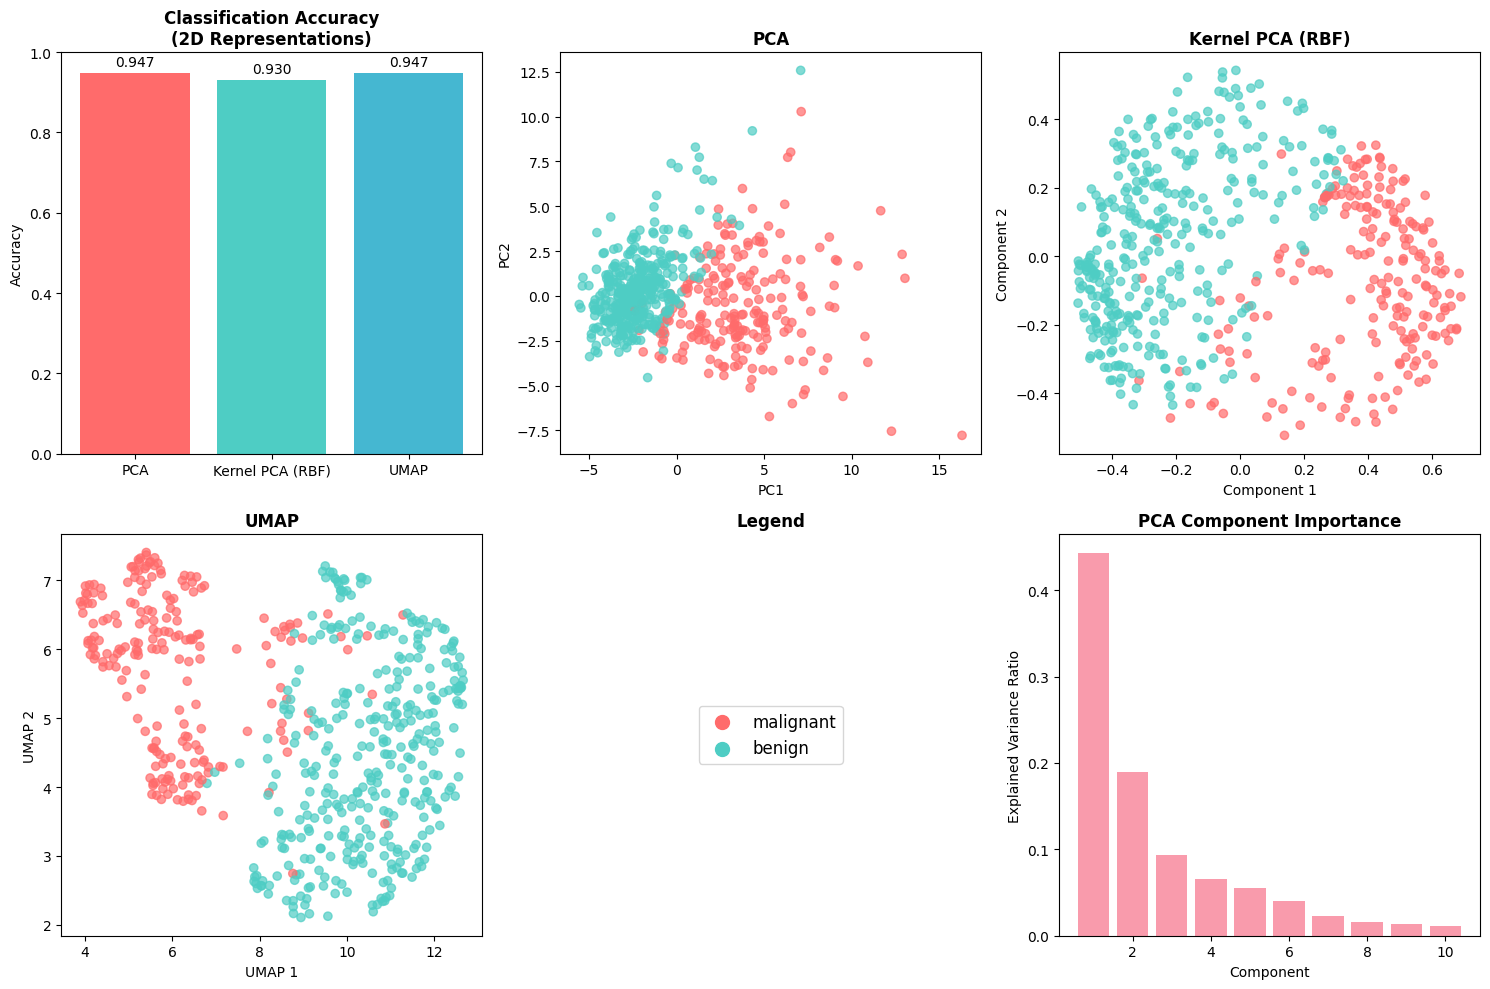


Dataset: Wisconsin Breast Cancer Dataset
Original dimensions: 30
Reduced dimensions: 2
Total samples: 569
Classes: 2


In [ ]:
# Wisconsin Breast Cancer Dataset - PCA vs Kernel PCA vs UMAP

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

print("=== Wisconsin Breast Cancer Dataset Analysis ===")
print("Comparing PCA, Kernel PCA, and UMAP for dimensionality reduction\n")

# Load the dataset
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Classes: {target_names}")
print(f"Class distribution: {np.bincount(y)}")

# Create DataFrame for easier handling
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['target_name'] = [target_names[i] for i in y]

print("\nFirst few rows of the dataset:")
print(df.head())

# Standardize the features (crucial for PCA and UMAP)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nFeatures standardized for dimensionality reduction")

# =============================================================================
# 1. PRINCIPAL COMPONENT ANALYSIS (PCA)
# =============================================================================

print("\n" + "="*50)
print("1. PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("="*50)

# Apply PCA
pca = PCA()
X_pca_full = pca.fit_transform(X_scaled)

# Calculate cumulative explained variance
cumsum_var = np.cumsum(pca.explained_variance_ratio_)

print(f"Explained variance by first 2 components: {cumsum_var[1]:.3f}")
print(f"Explained variance by first 5 components: {cumsum_var[4]:.3f}")
print(f"Explained variance by first 10 components: {cumsum_var[9]:.3f}")

# PCA for visualization (2 components)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print(f"\nPCA 2D - Explained variance ratio: {pca_2d.explained_variance_ratio_}")
print(f"Total explained variance (2D): {sum(pca_2d.explained_variance_ratio_):.3f}")

# =============================================================================
# 2. KERNEL PCA
# =============================================================================

print("\n" + "="*50)
print("2. KERNEL PCA")
print("="*50)

# Apply Kernel PCA with different kernels
kernels = ['rbf', 'poly', 'sigmoid']
X_kpca_results = {}

# For KernelPCA, we can use None (default) or calculate gamma manually
# None defaults to 1/n_features, but let's try a few different values
gamma_auto = 1.0 / X_scaled.shape[1]  # This is what gamma=None gives
gamma_scale = 1.0 / (X_scaled.shape[1] * X_scaled.var())  # This is like 'scale' in SVM

print(f"Using gamma values: auto={gamma_auto:.6f}, scale-like={gamma_scale:.6f}")

for kernel in kernels:
    print(f"\nApplying Kernel PCA with {kernel} kernel...")
    
    # Use the 'scale-like' gamma for better results
    if kernel == 'poly':
        kpca = KernelPCA(n_components=2, kernel=kernel, degree=3, gamma=gamma_scale)
    elif kernel == 'sigmoid':
        kpca = KernelPCA(n_components=2, kernel=kernel, gamma=gamma_scale, coef0=1)
    else:  # rbf
        kpca = KernelPCA(n_components=2, kernel=kernel, gamma=gamma_scale)
    
    X_kpca = kpca.fit_transform(X_scaled)
    X_kpca_results[kernel] = X_kpca
    
    print(f"Kernel PCA ({kernel}) shape: {X_kpca.shape}")

# =============================================================================
# 3. UMAP (Uniform Manifold Approximation and Projection)
# =============================================================================

print("\n" + "="*50)
print("3. UMAP (Uniform Manifold Approximation and Projection)")
print("="*50)

# Apply UMAP with different parameters
umap_configs = [
    {'n_neighbors': 15, 'min_dist': 0.1, 'name': 'default'},
    {'n_neighbors': 5, 'min_dist': 0.1, 'name': 'small_neighbors'},
    {'n_neighbors': 50, 'min_dist': 0.1, 'name': 'large_neighbors'},
    {'n_neighbors': 15, 'min_dist': 0.5, 'name': 'large_min_dist'}
]

X_umap_results = {}

for config in umap_configs:
    print(f"\nApplying UMAP with {config['name']} settings...")
    print(f"Parameters: n_neighbors={config['n_neighbors']}, min_dist={config['min_dist']}")
    
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=config['n_neighbors'],
        min_dist=config['min_dist'],
        random_state=42
    )
    
    X_umap = reducer.fit_transform(X_scaled)
    X_umap_results[config['name']] = X_umap
    
    print(f"UMAP ({config['name']}) shape: {X_umap.shape}")

# =============================================================================
# VISUALIZATION
# =============================================================================

print("\n" + "="*50)
print("CREATING VISUALIZATIONS")
print("="*50)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# Color map for consistency
colors = ['#FF6B6B', '#4ECDC4']
target_colors = [colors[i] for i in y]

# 1. Original data visualization (first 2 features)
plt.subplot(3, 4, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=target_colors, alpha=0.6)
plt.title('Original Data\n(First 2 Features)', fontsize=12, fontweight='bold')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')

# 2. PCA Explained Variance
plt.subplot(3, 4, 2)
plt.plot(range(1, min(21, len(cumsum_var)+1)), cumsum_var[:20], 'bo-', linewidth=2, markersize=6)
plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.7)
plt.title('PCA Explained Variance', fontsize=12, fontweight='bold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True, alpha=0.3)

# 3. PCA 2D
plt.subplot(3, 4, 3)
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=target_colors, alpha=0.6)
plt.title(f'PCA 2D\n({sum(pca_2d.explained_variance_ratio_):.1%} variance)', fontsize=12, fontweight='bold')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')

# 4. PCA Loadings/Components
plt.subplot(3, 4, 4)
components_df = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_names
)
# Show top contributing features
top_features = np.argsort(np.abs(components_df).sum(axis=1))[-10:]
sns.heatmap(components_df.iloc[top_features], annot=False, cmap='RdBu_r', center=0)
plt.title('PCA Components\n(Top 10 Features)', fontsize=12, fontweight='bold')
plt.xticks(rotation=0)

# 5-7. Kernel PCA results
for i, (kernel, X_kpca) in enumerate(X_kpca_results.items()):
    plt.subplot(3, 4, 5 + i)
    plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=target_colors, alpha=0.6)
    plt.title(f'Kernel PCA ({kernel.upper()})', fontsize=12, fontweight='bold')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

# 8. UMAP comparison placeholder
plt.subplot(3, 4, 8)
plt.text(0.5, 0.5, 'UMAP Comparison\n(See below)', ha='center', va='center', 
         fontsize=12, transform=plt.gca().transAxes)
plt.axis('off')

# 9-12. UMAP results
for i, (name, X_umap) in enumerate(X_umap_results.items()):
    plt.subplot(3, 4, 9 + i)
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=target_colors, alpha=0.6)
    plt.title(f'UMAP ({name.replace("_", " ")})', fontsize=12, fontweight='bold')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')

plt.tight_layout()
plt.show()

# =============================================================================
# QUANTITATIVE COMPARISON
# =============================================================================

print("\n" + "="*50)
print("QUANTITATIVE ANALYSIS")
print("="*50)

# Function to evaluate clustering quality using classification
def evaluate_representation(X_reduced, X_original, y, method_name):
    """Evaluate how well the reduced representation preserves class separability"""
    
    # Split data
    X_train_red, X_test_red, X_train_orig, X_test_orig, y_train, y_test = train_test_split(
        X_reduced, X_original, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Train classifier on reduced data
    clf_red = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_red.fit(X_train_red, y_train)
    y_pred_red = clf_red.predict(X_test_red)
    acc_red = accuracy_score(y_test, y_pred_red)
    
    # Train classifier on original data (for comparison)
    clf_orig = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_orig.fit(X_train_orig, y_train)
    y_pred_orig = clf_orig.predict(X_test_orig)
    acc_orig = accuracy_score(y_test, y_pred_orig)
    
    print(f"\n{method_name}:")
    print(f"  Accuracy on reduced data: {acc_red:.3f}")
    print(f"  Accuracy on original data: {acc_orig:.3f}")
    print(f"  Relative performance: {acc_red/acc_orig:.3f}")
    
    return acc_red, acc_orig

# Evaluate all methods
results = {}

# PCA
acc_red, acc_orig = evaluate_representation(X_pca_2d, X_scaled, y, "PCA (2D)")
results['PCA'] = {'reduced': acc_red, 'original': acc_orig}

# Kernel PCA (RBF)
acc_red, acc_orig = evaluate_representation(X_kpca_results['rbf'], X_scaled, y, "Kernel PCA (RBF)")
results['Kernel PCA (RBF)'] = {'reduced': acc_red, 'original': acc_orig}

# UMAP (default)
acc_red, acc_orig = evaluate_representation(X_umap_results['default'], X_scaled, y, "UMAP (default)")
results['UMAP'] = {'reduced': acc_red, 'original': acc_orig}

# =============================================================================
# SUMMARY AND ANALYSIS
# =============================================================================

print("\n" + "="*60)
print("SUMMARY AND ANALYSIS")
print("="*60)

print("\n1. EXPLAINED VARIANCE (PCA only):")
print(f"   - First 2 components explain {sum(pca_2d.explained_variance_ratio_):.1%} of variance")
print(f"   - First 5 components explain {cumsum_var[4]:.1%} of variance")
print(f"   - First 10 components explain {cumsum_var[9]:.1%} of variance")

print("\n2. CLASSIFICATION PERFORMANCE COMPARISON:")
for method, scores in results.items():
    rel_perf = scores['reduced'] / scores['original']
    print(f"   - {method}: {scores['reduced']:.3f} ({rel_perf:.1%} of original performance)")

print("\n3. VISUAL SEPARATION QUALITY:")
print("   Based on the visualizations above:")
print("   - PCA: Linear transformation, preserves global structure")
print("   - Kernel PCA: Non-linear, can capture more complex relationships")
print("   - UMAP: Best for preserving local neighborhood structure")

print("\n4. RECOMMENDATIONS:")
print("   - For interpretability: Use PCA (linear, easy to understand)")
print("   - For non-linear patterns: Use Kernel PCA or UMAP")
print("   - For visualization: UMAP often provides clearest separation")
print("   - For downstream ML: Test all methods with your specific classifier")

print("\n5. MATHEMATICAL PROPERTIES:")
print("   - PCA: Maximizes variance, finds principal components")
print("   - Kernel PCA: PCA in higher-dimensional space via kernel trick")
print("   - UMAP: Preserves topological structure using manifold learning")

print("\nAnalysis complete! Use these results for your linear algebra final project.")

# Create a final comparison plot
plt.figure(figsize=(15, 10))

# Performance comparison
plt.subplot(2, 3, 1)
methods = list(results.keys())
performances = [results[m]['reduced'] for m in methods]
bars = plt.bar(methods, performances, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Classification Accuracy\n(2D Representations)', fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for bar, perf in zip(bars, performances):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{perf:.3f}', ha='center', va='bottom')

# Side-by-side comparison of best results
plt.subplot(2, 3, 2)
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=target_colors, alpha=0.7)
plt.title('PCA', fontweight='bold')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(2, 3, 3)
plt.scatter(X_kpca_results['rbf'][:, 0], X_kpca_results['rbf'][:, 1], c=target_colors, alpha=0.7)
plt.title('Kernel PCA (RBF)', fontweight='bold')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.subplot(2, 3, 4)
plt.scatter(X_umap_results['default'][:, 0], X_umap_results['default'][:, 1], c=target_colors, alpha=0.7)
plt.title('UMAP', fontweight='bold')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Legend
plt.subplot(2, 3, 5)
for i, (color, label) in enumerate(zip(colors, target_names)):
    plt.scatter([], [], c=color, label=label, s=100)
plt.legend(loc='center', fontsize=12)
plt.axis('off')
plt.title('Legend', fontweight='bold')

# Add explained variance for PCA
plt.subplot(2, 3, 6)
components = range(1, min(11, len(pca.explained_variance_ratio_) + 1))
plt.bar(components, pca.explained_variance_ratio_[:10], alpha=0.7)
plt.title('PCA Component Importance', fontweight='bold')
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')

plt.tight_layout()
plt.show()

print(f"\nDataset: Wisconsin Breast Cancer Dataset")
print(f"Original dimensions: {X.shape[1]}")
print(f"Reduced dimensions: 2")
print(f"Total samples: {X.shape[0]}")
print(f"Classes: {len(np.unique(y))}")